In [4]:
#  limitations under the License.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn import datasets, cross_validation, metrics
import tensorflow as tf

from tensorflow.contrib import learn
from tensorflow.contrib.learn import monitors


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


## Two Images Dataset

In [11]:
#benign_file = '/Users/chitrangtalaviya/Documents/Tensorflow/all-images/200X/benign_p/BENIGN0.p'
#malignant_file = '/Users/chitrangtalaviya/Documents/Tensorflow/all-images/200X/malignant_p/MALIGNANT0.p'
benign_file = 'small-data/BENIGN.pkl'
malignant_file = 'small-data/MALIGNANT.pkl'

benign_arr = pickle.load(open(benign_file, 'rb'))
malignant_arr = pickle.load(open(malignant_file, 'rb'))

(1009, 32, 32, 3)
(1009, 32, 32, 3)


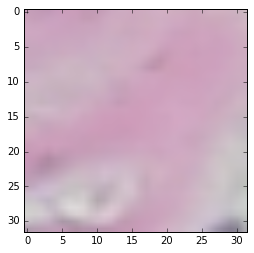

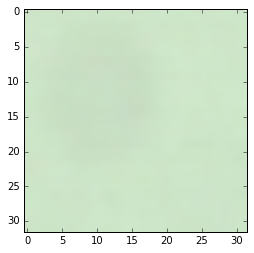

In [15]:
print(benign_arr.shape)
plt.figure()
plt.imshow(benign_arr[0])
print(malignant_arr.shape)
plt.figure()
plt.imshow(malignant_arr[0])

In [16]:
X = np.concatenate((benign_arr, malignant_arr), axis=0)
X.shape

(2018, 32, 32, 3)

In [17]:
y = np.concatenate((np.zeros(1009), np.ones(1009)))
y.shape

(2018,)

## Run

## Model Definition (for Train and Predict)

In [18]:
test_size = 1009

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))


def model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden):
    l1a = tf.nn.relu(tf.nn.conv2d(X, w,                       # l1a shape=(?, 28, 28, 32)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],              # l1 shape=(?, 14, 14, 32)
                        strides=[1, 2, 2, 1], padding='SAME')
    l1 = tf.nn.dropout(l1, p_keep_conv)

    l2a = tf.nn.relu(tf.nn.conv2d(l1, w2,                     # l2a shape=(?, 14, 14, 64)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],              # l2 shape=(?, 7, 7, 64)
                        strides=[1, 2, 2, 1], padding='SAME')
    l2 = tf.nn.dropout(l2, p_keep_conv)

    l3a = tf.nn.relu(tf.nn.conv2d(l2, w3,                     # l3a shape=(?, 7, 7, 128)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],              # l3 shape=(?, 4, 4, 128)
                        strides=[1, 2, 2, 1], padding='SAME')
    l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]])    # reshape to (?, 2048)
    l3 = tf.nn.dropout(l3, p_keep_conv)

    l4 = tf.nn.relu(tf.matmul(l3, w4))
    l4 = tf.nn.dropout(l4, p_keep_hidden)

    pyx = tf.matmul(l4, w_o)
    return pyx


X = tf.placeholder("float", [None, 32, 32, 3])
Y = tf.placeholder("float", [None, 2])
Y1 = tf.placeholder("float", [test_size,])
w = init_weights([3, 3, 3, 32])       # 3x3x1 conv, 32 outputs
w2 = init_weights([3, 3, 32, 64])     # 3x3x32 conv, 64 outputs
w3 = init_weights([3, 3, 64, 128])    # 3x3x32 conv, 128 outputs
w4 = init_weights([128 * 4 * 4, 625]) # FC 128 * 4 * 4 inputs, 625 outputs
w_o = init_weights([625, 2])         # FC 625 inputs, 10 outputs (labels)

p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")
py_x = model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(py_x, Y))
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)

# saver object
saver = tf.train.Saver()


## Prediction

In [20]:
X_to_predict = benign_arr
#X_to_predict = malignant_arr

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/model.ckpt")
    print("Model restored.")
    
    res = sess.run(predict_op, feed_dict={X: X_to_predict,
                                                     p_keep_conv: 1.0,
                                                     p_keep_hidden: 1.0})
    print( res )

Model restored.
[0 0 0 ..., 0 0 0]


In [22]:
print('Mean patch output: %f' % (np.mean(res)))

Mean patch output: 0.000991


In [14]:
#X_to_predict = benign_arr
X_to_predict = malignant_arr

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/model.ckpt")
    print("Model restored.")
    
    print(sess.run(predict_op, feed_dict={X: X_to_predict,
                                                     p_keep_conv: 1.0,
                                                     p_keep_hidden: 1.0}) )

Model restored.
[0 0 0 ..., 0 0 0]
